# Training Various Boosting Models on Datasets

In [12]:
import torch
import numpy as np
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import pandas as pd

diabetes_012_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_012_health_indicators_BRFSS2015.csv'
diabetes_binary_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_binary_health_indicators_BRFSS2015.csv'
diabetes_binary_5050split_health_indicators_BRFSS2015 = 'https://raw.githubusercontent.com/Panta-Rhei-LZ/DS-9000-Project-Data/refs/heads/main/diabetes_binary_5050split_health_indicators_BRFSS2015.csv'

# Load the CSV file
diabetes_012_health_indicators_BRFSS2015 = pd.read_csv(diabetes_012_health_indicators_BRFSS2015)
diabetes_binary_health_indicators_BRFSS2015 = pd.read_csv(diabetes_binary_health_indicators_BRFSS2015)
diabetes_binary_5050split_health_indicators_BRFSS2015 = pd.read_csv(diabetes_binary_5050split_health_indicators_BRFSS2015)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Current device is: {device}')

Current device is: cuda


In [17]:
def confusion_plot(labels, preds, name='', classes=[0, 1, 2]):

    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    print(f'{name} accuracy: {accuracy * 100:.2f}%')

    # Compute the confusion matrix
    cf = confusion_matrix(labels, preds, labels=classes, normalize='true')

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf, annot=True, xticklabels=classes, yticklabels=classes, cmap="Blues", fmt=".2f")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    return preds

In [9]:
def paramGridSearchCV(model, param_grid, X_train, y_train, num_cv=3, verbose=3):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=num_cv, verbose=verbose)
    grid_search.fit(X_train, y_train)

    # Best parameters
    best_params = grid_search.best_params_
    print(best_params)

    return best_params

### 1. XGBoost on 5050-split Binary

In [99]:
# 5050-split binary dataset
# `diabetes_binary_5050split_health_indicators_BRFSS2015`
X_diabetes01_5050 = diabetes_binary_5050split_health_indicators_BRFSS2015.drop(['Diabetes_binary'], axis=1)
y_diabetes01_5050 = diabetes_binary_5050split_health_indicators_BRFSS2015.Diabetes_binary

X_train_diabetes01_5050, X_test_diabetes01_5050, y_train_diabetes01_5050, y_test_diabetes01_5050 = train_test_split(
    X_diabetes01_5050, y_diabetes01_5050, test_size=0.2, stratify=y_diabetes01_5050, random_state=11
)

In [ ]:
# Define the parameter grid
param_grid_diabetes01_5050 = {
    'eta': [0.01, 0.025, 0.05, 0.075, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 200, 300, 400, 500],
    'min_child_weight': [1, 3, 5],
    'device': ['cuda'],
    'verbosity': [0],
    'objective': ['binary:logistic']
}

model = xgb.XGBClassifier()

best_params_diabetes01_5050 = paramGridSearchCV(
    model, param_grid_diabetes01_5050, X_train_diabetes01_5050, y_train_diabetes01_5050
)


Fitting 3 folds for each of 225 candidates, totalling 675 fits
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=100, verbosity=0;, score=0.729 total time=   0.3s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=100, verbosity=0;, score=0.733 total time=   0.0s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=100, verbosity=0;, score=0.735 total time=   0.0s
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=200, verbosity=0;, score=0.729 total time=   0.1s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=200, verbosity=0;, score=0.733 total time=   0.1s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=200, verbosity=0;, score=0.735 total time=   0.0s
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, num_boost_round=300, verbosity=0;, score=0.729 total time=

In [19]:
# Use best params from GridSearchCV
dtrain_diabetes01_5050 = xgb.DMatrix(X_train_diabetes01_5050, label=y_train_diabetes01_5050)

model_diabetes01_5050 = xgb.train(
    params=best_params_diabetes01_5050,
    dtrain=dtrain_diabetes01_5050
)

In [25]:
# Make Predictions on the validation set
dtest_diabetes01_5050 = xgb.DMatrix(X_test_diabetes01_5050, label=y_test_diabetes01_5050)

# Make predictions on the test set
preds_diabetes01_5050 = (model_diabetes01_5050.predict(dtest_diabetes01_5050) >= 0.5).astype(int)

Train accuracy: 75.15%


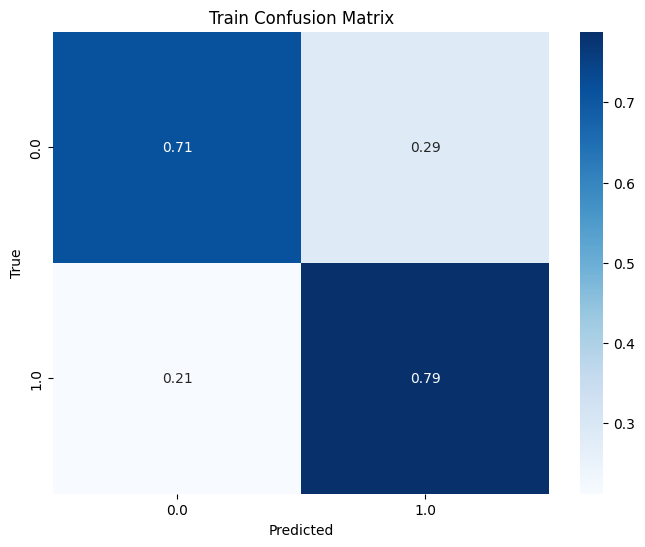

array([0, 1, 1, ..., 1, 1, 0])

In [31]:
confusion_plot(
    y_train_diabetes01_5050, 
    (model_diabetes01_5050.predict(dtrain_diabetes01_5050) >= 0.5).astype(int),
    'Train',
    list(set(y_train_diabetes01_5050)))

Valid accuracy: 75.25%


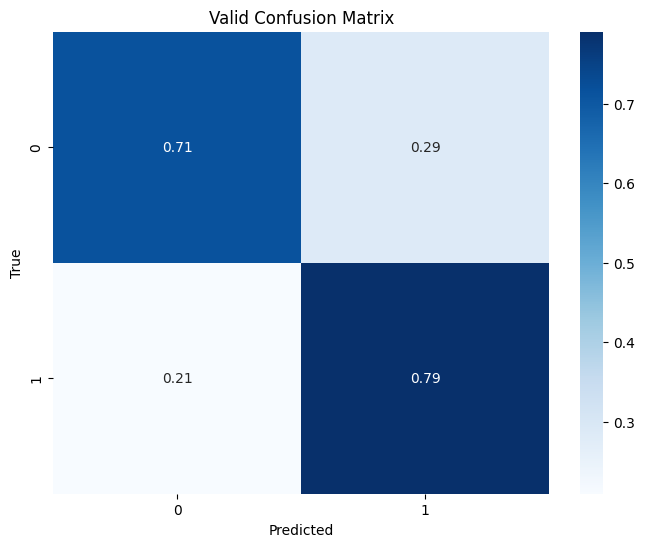

array([1, 1, 1, ..., 0, 0, 1])

In [ ]:
confusion_plot(
    y_test_diabetes01_5050, 
    preds_diabetes01_5050,
    'Valid',
    list(set(y_train_diabetes01_5050)))

### 1. XGBoost on Diabetes_012

In [100]:
from imblearn.under_sampling import NearMiss

# diabetes012 dataset
# `diabetes_012_health_indicators_BRFSS2015`
X_diabetes012 = diabetes_012_health_indicators_BRFSS2015.drop(['Diabetes_012'], axis=1)
y_diabetes012 = diabetes_012_health_indicators_BRFSS2015.Diabetes_012

# Deal with imbalance
nm = NearMiss(version=1 , n_neighbors=10)
X_diabetes012_sm, y_diabetes012_sm= nm.fit_resample(X_diabetes012, y_diabetes012)

X_train_diabetes012_sm, X_test_diabetes012_sm, y_train_diabetes012_sm, y_test_diabetes012_sm = train_test_split(
    X_diabetes012_sm, y_diabetes012_sm, test_size=0.2, stratify=y_diabetes012_sm, random_state=11
)

X_train_diabetes012, X_test_diabetes012, y_train_diabetes012, y_test_diabetes012 = train_test_split(
    X_diabetes012, y_diabetes012, test_size=0.2, stratify=y_diabetes012, random_state=11
)

In [101]:
y_train_diabetes012.value_counts()

Diabetes_012
0.0    170962
2.0     28277
1.0      3705
Name: count, dtype: int64

In [102]:
y_test_diabetes012_sm.value_counts()

Diabetes_012
1.0    927
2.0    926
0.0    926
Name: count, dtype: int64

In [103]:
y_diabetes012_sm.value_counts()

Diabetes_012
0.0    4631
1.0    4631
2.0    4631
Name: count, dtype: int64

In [105]:
# Define the parameter grid
param_grid_diabetes012 = {
    'eta': [0.01, 0.05, 0.1],
    'max_depth': [2, 4, 6],
    'n_estimators': [100, 300, 500],
    'min_child_weight': [1, 3, 5],
    'device': ['cuda'],
    'verbosity': [0],
    'objective': ['multi:softmax'],
    'num_class': [3]
}

model = xgb.XGBClassifier()

best_params_diabetes012 = paramGridSearchCV(
    model, param_grid_diabetes012, X_train_diabetes012_sm, y_train_diabetes012_sm
)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, num_class=3, objective=multi:softmax, verbosity=0;, score=0.705 total time=   0.4s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, num_class=3, objective=multi:softmax, verbosity=0;, score=0.693 total time=   0.2s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=100, num_class=3, objective=multi:softmax, verbosity=0;, score=0.680 total time=   0.2s
[CV 1/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, num_class=3, objective=multi:softmax, verbosity=0;, score=0.740 total time=   0.7s
[CV 2/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, num_class=3, objective=multi:softmax, verbosity=0;, score=0.738 total time=   0.8s
[CV 3/3] END device=cuda, eta=0.01, max_depth=2, min_child_weight=1, n_estimators=300, n

In [114]:
# Use best params from GridSearchCV
dtrain_diabetes012 = xgb.DMatrix(X_train_diabetes012_sm, label=y_train_diabetes012_sm)

model_diabetes012 = xgb.train(
    params=best_params_diabetes012,
    dtrain=dtrain_diabetes012
)

In [115]:
# Make Predictions on the validation set
dtest_diabetes012 = xgb.DMatrix(X_test_diabetes012, label=y_test_diabetes012)

# Make predictions on the test set
preds_diabetes012 = model_diabetes012.predict(dtest_diabetes012)

Train accuracy: 21.01%


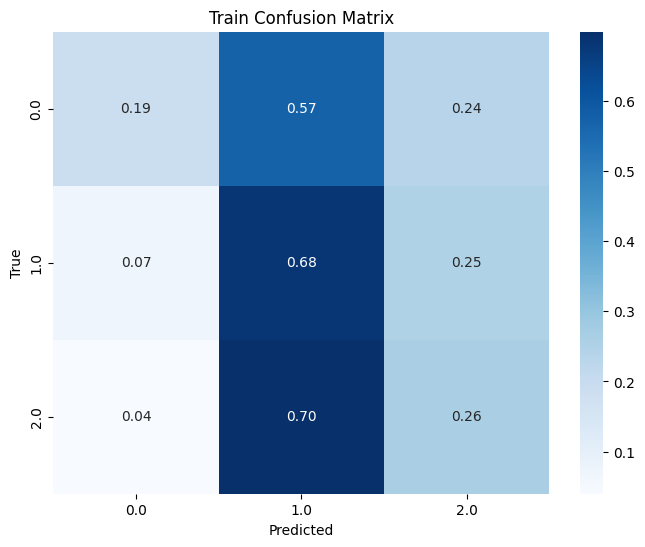

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [116]:
confusion_plot(
    y_train_diabetes012, 
    model_diabetes012.predict(xgb.DMatrix(X_train_diabetes012, label=y_train_diabetes012)),
    'Train',
    list(set(y_train_diabetes012)))

Valid accuracy: 21.26%


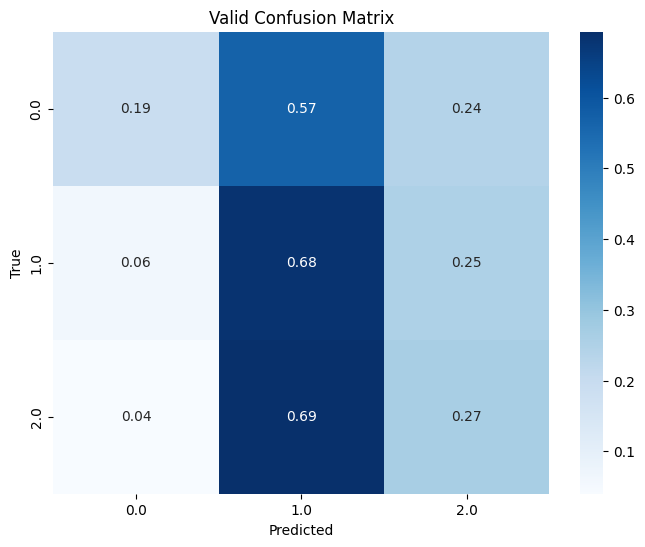

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [117]:
confusion_plot(
    y_test_diabetes012, 
    preds_diabetes012,
    'Valid',
    list(set(y_train_diabetes012)))

### 1. XGBoost on Diabetes_binary Imbalance

In [ ]:
# diabetes_binary dataset
# `diabetes_binary_health_indicators_BRFSS2015`
X_diabetes01 = diabetes_binary_health_indicators_BRFSS2015.drop(['Diabetes_binary'], axis=1)
y_diabetes01 = diabetes_binary_health_indicators_BRFSS2015.Diabetes_binary

X_train_diabetes01, X_test_diabetes01, y_train_diabetes01, y_test_diabetes01 = train_test_split(
    X_diabetes01, y_diabetes01, test_size=0.2, stratify=y_diabetes01, random_state=11
)